# DCASE-2020 Video Subnetwork

Author: Maximo Cobos


In [ ]:
# Import necessary standard packages
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Input Data

Specify path to folder containing the video dataset and the output path for the tfrecords:

In [ ]:
# TFRecords folder
main_dir = '.\\tfrecords_gamma'
root_path = Path(main_dir)

# Train Fold
train_fold_path = '.\\dataset\\evaluation_setup\\fold1_train.csv'
traindf = pd.read_csv(train_fold_path, sep='\t', lineterminator='\r')
trainlist = traindf[traindf.columns[1]].tolist()
trainfiles = [Path(f).with_suffix('.tfrecords').name for f in trainlist]

# Validation Fold
val_fold_path = '.\\dataset\\evaluation_setup\\fold1_test.csv'
valdf = pd.read_csv(val_fold_path, sep='\t', lineterminator='\r')
vallist = valdf[valdf.columns[1]].tolist()
valfiles = [Path(f).with_suffix('.tfrecords').name for f in vallist]

len(trainfiles), len(valfiles)

(8646, 3645)

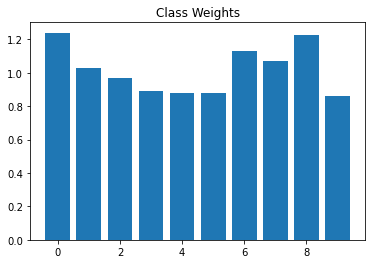

In [ ]:
def get_label(filepath):
    '''Receives a path to a video and returns its label
    '''
    scn_dict = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 
                'street_pedestrian': 3, 'public_square': 4, 'street_traffic': 5,
                'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    
    fileid = Path(filepath).name
    scn_id = fileid.split('-')[0]
    label = scn_dict[scn_id]
    return label

# Get labels
train_labels = [get_label(f) for f in trainfiles]
val_labels = [get_label(f) for f in valfiles]

trainfiles = [main_dir + '\\' + str(label) + '\\' + f for f,label in zip(trainfiles,train_labels)]
valfiles = [main_dir + '\\' + str(label) + '\\' + f for f,label in zip(valfiles,val_labels)]

N_val = len(valfiles)

# Get number of examples per class
num_class_ex = []
for i in range(10):
    num_class_ex.append(train_labels.count(i))     


# Get class weights    
N_train = len(train_labels)
num_classes = 10
class_weights = []
for i in range(num_classes):
    weight = ( 1 / num_class_ex[i]) * N_train / num_classes
    class_weights.append(weight)  

keylst = np.arange(0,len(class_weights))
class_weights = {keylst[i]: class_weights[i] for i in range(0, len(class_weights))}    

plt.bar(class_weights.keys(), class_weights.values())
plt.title('Class Weights');


### Parsing function

In [ ]:
def parse_sequence(sequence_example, avmode = 'audiovideo'):
    """this function is the sequence parser for the created TFRecords file"""
    
    sequence_features = {'VideoFrames': tf.io.FixedLenSequenceFeature([], dtype=tf.string),                    
                         'Labels': tf.io.FixedLenSequenceFeature([], dtype=tf.int64)}

    context_features = {'AudioFrames': tf.io.FixedLenFeature((96000,), dtype=tf.float32),
                        'length': tf.io.FixedLenFeature([], dtype=tf.int64)}
    context, sequence = tf.io.parse_single_sequence_example(
    sequence_example, context_features=context_features, sequence_features=sequence_features)

    # get features context
    seq_length = tf.cast(context['length'], dtype = tf.int32)   

    # decode video and audio
    video = tf.io.decode_raw(sequence['VideoFrames'], tf.uint8)
    video = tf.reshape(video, shape=(seq_length, 224, 224, 3))
    audio = tf.cast(context['AudioFrames'], tf.float32)
    audio = tf.reshape(audio, shape=(64, 500, 3))
    label = tf.cast(sequence['Labels'], dtype = tf.int32)
        
    video = tf.cast(video, tf.float32)
    
    if avmode == 'audio':
        return audio, label
    elif avmode == 'video':
        return video, label
    elif avmode == 'audiovideo':
        return video, audio, label

In [ ]:
# Check parsing function
filesds = tf.data.Dataset.from_tensor_slices(trainfiles)
dataset = tf.data.TFRecordDataset(filesds)
dataset = dataset.map(lambda tf_file: parse_sequence(tf_file,'video'), num_parallel_calls=4)
datait = iter(dataset)
example = datait.get_next()
print(example[0].shape, example[1].shape)

(50, 224, 224, 3) (50,)


## Video Pipeline

In [ ]:
def random_cut_video(video):
    ''' Extract randomly one second of video (5 frames)
    '''
    seq_length = tf.shape(video)[0]
    min_v = 0
    max_v = seq_length - 5
    rnum = tf.random.uniform([1], minval=min_v, maxval=max_v, dtype=tf.dtypes.int32)
    video = video[rnum[0]:rnum[0]+5,...]
    return video

def process_ds_video(video,label):
    ''' Process video in training
    '''
    video = random_cut_video(video)
    label = label[0]    
    label = tf.one_hot(label,10)
    return video, label

def process_ds_video_val(video,label):
    ''' Process video in validation (reshapes a 10 second file into 10 different examples)
    '''
    video = tf.reshape(video, shape=[10,5,224,224,3])
    label = label[0:10]
    label = tf.one_hot(label,10)
    return video, label

In [ ]:
# Generate Train tf.data.dataset
train_batch_size = 16

trainds = tf.data.Dataset.from_tensor_slices(trainfiles)
trainds = trainds.shuffle(N_train)
trainds = trainds.repeat()  
    
trainds = tf.data.TFRecordDataset(trainds)
trainds = trainds.map(lambda tf_file: parse_sequence(tf_file,'video'), num_parallel_calls=4)
trainds = trainds.map(lambda video, label: process_ds_video(video, label), num_parallel_calls=4)
trainds = trainds.batch(train_batch_size)  

# Generate Validation dataset

#val_batch_size = 16

valds = tf.data.Dataset.from_tensor_slices(valfiles)
valds = tf.data.TFRecordDataset(valds)
valds = valds.map(lambda tf_file: parse_sequence(tf_file,'video'), num_parallel_calls=4)
valds = valds.map(lambda video, label: process_ds_video_val(video, label), num_parallel_calls=4)
#valds = valds.batch(val_batch_size)  

In [ ]:
datait = iter(trainds)
example = datait.get_next()
print(example[0].shape, example[1].shape)

(16, 5, 224, 224, 3) (16, 10)


In [ ]:
datait = iter(valds)
example = datait.get_next()
print(example[0].shape, example[1].shape)

(10, 5, 224, 224, 3) (10, 10)


## Create model

In [ ]:
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Dropout, SpatialDropout1D, Dense, SpatialDropout2D
from tensorflow.keras.layers import TimeDistributed, GRU, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.models import save_model, load_model

### First step: Create Time-Distributed VGG16 trained on Places365

First step: Load pre-trained model

In [ ]:
pre_model = load_model('PATH_TO\vgg16_places_t2_1x.hdf5', compile=False)

Second step: Make the equivalent Time-Distributed model and transfer weights

In [ ]:
regularization = l2(0.001)    

num_classes = 10 
input_shape = (None,224,224,3)
input_vid = Input(shape = input_shape)

# Block 1
x = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block1_conv1')(input_vid)

x = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block1_conv2')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block1_pool")(x)

# Block 2
x = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block2_conv1')(x)

x = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block2_conv2')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block2_pool")(x)

# Block 3
x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv1')(x)

x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv2')(x)

x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block3_pool")(x)

# Block 4
x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv1')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv2')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block4_pool")(x)

# Block 5
x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv1')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv2')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block5_pool")(x)


vggpre = Model(inputs=input_vid, outputs=x)  
vggpre.load_weights('PATH_TO\vgg16_places_t2_1x.hdf5', by_name = False)

# Freeze all weights

for layer in vggpre.layers:
    print('Setting layer {} non-trainable'.format(layer.name))
    layer.trainable = False

vggpre.summary()

Setting layer input_2 non-trainable
Setting layer block1_conv1 non-trainable
Setting layer block1_conv2 non-trainable
Setting layer block1_pool non-trainable
Setting layer block2_conv1 non-trainable
Setting layer block2_conv2 non-trainable
Setting layer block2_pool non-trainable
Setting layer block3_conv1 non-trainable
Setting layer block3_conv2 non-trainable
Setting layer block3_conv3 non-trainable
Setting layer block3_pool non-trainable
Setting layer block4_conv1 non-trainable
Setting layer block4_conv2 non-trainable
Setting layer block4_conv3 non-trainable
Setting layer block4_pool non-trainable
Setting layer block5_conv1 non-trainable
Setting layer block5_conv2 non-trainable
Setting layer block5_conv3 non-trainable
Setting layer block5_pool non-trainable
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 224, 224, 3 0         
________________

Third step: Add recurrent part

In [ ]:

x = TimeDistributed(GlobalMaxPooling2D(), name='TD_C_GlobAvPooling2D')(vggpre.layers[-1].output)

# Recurrent Block
fw = GRU(32, return_sequences=True, stateful=False, recurrent_dropout = 0.0, name='VID_RNN_fw')
bw = GRU(32, return_sequences=True, stateful=False, recurrent_dropout = 0.0, go_backwards=True, name='VID_RNN_bw')
x = Bidirectional(fw, backward_layer=bw, name='VID_RNN_bidir')(x) 
x = Dropout(0.5, name='VID_C2_Dropout')(x) 
x = Dense(num_classes, kernel_regularizer = regularization, name ='VID_C2_Dense')(x)
x = Activation('softmax', name = 'VID_C2_Act_softmax_1')(x)
x = GlobalAveragePooling1D(name='VID_Pred')(x)
          
video_model = Model(inputs=input_vid, outputs=x)  
video_model.summary()
   

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 224, 224, 3 0         
_________________________________________________________________
block1_conv1 (TimeDistribute (None, None, 224, 224, 64 1792      
_________________________________________________________________
block1_conv2 (TimeDistribute (None, None, 224, 224, 64 36928     
_________________________________________________________________
block1_pool (TimeDistributed (None, None, 112, 112, 64 0         
_________________________________________________________________
block2_conv1 (TimeDistribute (None, None, 112, 112, 12 73856     
_________________________________________________________________
block2_conv2 (TimeDistribute (None, None, 112, 112, 12 147584    
_________________________________________________________________
block2_pool (TimeDistributed (None, None, 56, 56, 128) 0   

## Train Model

In [ ]:
# Compile model
learning_rate = 0.0001
opt = tf.keras.optimizers.get('adam')
tf.keras.backend.set_value(opt.learning_rate, learning_rate)

video_model.compile(
    loss = {'VID_Pred': 'categorical_crossentropy'},
    optimizer=opt,            
    metrics = {'VID_Pred': 'accuracy'},
)      

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
callbacks = []
ckpt_dir = 'PATH_WHERE\checkpoints'
model_name = 'video_final'
callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, '%s-{epoch:02d}-{val_accuracy:.2f}.hdf5' % model_name),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                save_weights_only=True,
                verbose=True,
            )
        )

callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=40,
                )
            )

callbacks.append(
                ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.5, 
                    patience=20, 
                    verbose=True,
                )
            )

callbacks.append(
    CSVLogger(                    
        filename = os.path.join(ckpt_dir, '%s.csv' % model_name),
        append = False,                
    )
)

In [ ]:
# Train model
history = video_model.fit(
            trainds,
            epochs=200,
            steps_per_epoch= int(N_train/train_batch_size),    # Set according to number of examples and training batch size
            validation_data = valds,
            validation_steps = int(N_val),
            callbacks=callbacks,  # Include list of callbacks    
            #class_weight = class_weights,    
        )

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Note: I trained the above model freezing all pre-trained weights and achieved 0.81% accuracy.
In this second try, I unfreeze all layers and lower to a very small learning rate

In [ ]:
video_model.load_weights('PATH_TO_BEST_VIDEO_MODEL')
for layer in video_model.layers:
    print('Setting layer {} non-trainable'.format(layer.name))
    layer.trainable = True

Setting layer input_2 non-trainable
Setting layer block1_conv1 non-trainable
Setting layer block1_conv2 non-trainable
Setting layer block1_pool non-trainable
Setting layer block2_conv1 non-trainable
Setting layer block2_conv2 non-trainable
Setting layer block2_pool non-trainable
Setting layer block3_conv1 non-trainable
Setting layer block3_conv2 non-trainable
Setting layer block3_conv3 non-trainable
Setting layer block3_pool non-trainable
Setting layer block4_conv1 non-trainable
Setting layer block4_conv2 non-trainable
Setting layer block4_conv3 non-trainable
Setting layer block4_pool non-trainable
Setting layer block5_conv1 non-trainable
Setting layer block5_conv2 non-trainable
Setting layer block5_conv3 non-trainable
Setting layer block5_pool non-trainable
Setting layer TD_C_GlobAvPooling2D non-trainable
Setting layer VID_RNN_bidir non-trainable
Setting layer VID_C2_Dropout non-trainable
Setting layer VID_C2_Dense non-trainable
Setting layer VID_C2_Act_softmax_1 non-trainable
Setting

In [ ]:
# Compile model
learning_rate = 0.000001 # 0.0001 was the original learning rate with frozen weights. I lowered in order not to destroy weights
opt = tf.keras.optimizers.get('adam')
tf.keras.backend.set_value(opt.learning_rate, learning_rate)

video_model.compile(
    loss = {'VID_Pred': 'categorical_crossentropy'},
    optimizer=opt,            
    metrics = {'VID_Pred': 'accuracy'},
)      

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
callbacks = []
ckpt_dir = 'PATH_WHERE\checkpoints'
model_name = 'video_final_un'
callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, '%s-{epoch:02d}-{val_accuracy:.2f}.hdf5' % model_name),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                save_weights_only=True,
                verbose=True,
            )
        )

callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=40,
                )
            )

callbacks.append(
                ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.5, 
                    patience=20, 
                    verbose=True,
                )
            )

callbacks.append(
    CSVLogger(                    
        filename = os.path.join(ckpt_dir, '%s.csv' % model_name),
        append = False,                
    )
)

In [ ]:
# Train model
history = video_model.fit(
            trainds,
            epochs=200,
            steps_per_epoch= int(N_train/train_batch_size),    # Set according to number of examples and training batch size
            validation_data = valds,
            validation_steps = int(N_val),
            #validation_steps = int(N_val/val_batch_size),
            callbacks=callbacks,  # Include list of callbacks    
            #class_weight = class_weights,    
        )

In [ ]:
model_name = 'video_final_un2'
callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, '%s-{epoch:02d}-{val_accuracy:.2f}.hdf5' % model_name),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                save_weights_only=True,
                verbose=True,
            )
        )

callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=40,
                )
            )

callbacks.append(
                ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.5, 
                    patience=20, 
                    verbose=True,
                )
            )

callbacks.append(
    CSVLogger(                    
        filename = os.path.join(ckpt_dir, '%s.csv' % model_name),
        append = False,                
    )
)


# Train model
history = video_model.fit(
            trainds,
            epochs=200,
            steps_per_epoch= int(N_train/train_batch_size),    # Set according to number of examples and training batch size
            validation_data = valds,
            validation_steps = int(N_val),
            #validation_steps = int(N_val/val_batch_size),
            callbacks=callbacks,  # Include list of callbacks    
            #class_weight = class_weights,    
        )

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
save_model(video_model, 'VGG16_RCNN_unpvideo3_86.hdf5')